## Import Necessary Packages

In [1]:
# OS
import os
import argparse

In [2]:
# Maths
import numpy as np
import math

In [3]:
# Pytorch
import torch as torch
import torch.nn as nn
import torch.utils.data as data

In [4]:
# AtomNet and its utilities
from network.atomNet import AtomNet
from utils import *

In [5]:
# Plotting
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn as sns

In [6]:
# Image IO Preprocessing
from skimage import io
from skimage import exposure
from skimage.filters import difference_of_gaussians, window
from skimage.exposure import histogram

In [7]:
%matplotlib widget

In [8]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Define Paths

In [15]:
data_path = './Raw_images_single/Pt on C3N4.tif' # Raw Data Path
save_path = "./Data/Results_1/Pt_CN_80kV_15Mx/" # Save Path
restore_from = './snapshots/iter_96000.pth' # Pretrained AtomNet

In [16]:
# Detect if save path exists
# If not, create one
if not os.path.exists(save_path):
        os.makedirs(save_path)

In [21]:
datapath = data_path

# Prepare model

In [18]:
model = AtomNet()
# See if GPU acceleration is possible, if not, use CPU
if torch.cuda.is_available():
    model.cuda()
    saved_state_dict = torch.load(restore_from,map_location='gpu')
    device = 'cuda'
else:
    saved_state_dict = torch.load(restore_from,map_location='cpu')
    device = 'cpu'
model.load_state_dict(saved_state_dict)

<All keys matched successfully>

# Prepare Dataloader

In [31]:
class TEMDataset(data.Dataset):
    def __init__(self, data_path):
        super(TEMDataset, self).__init__()
        im = io.imread(data_path)
        self.im = im
        
    def DoG(self, img, low_sigma, high_sigma = None):
        # Remove Background (Bandpass Filtering) by DoG
        # Filtering kernels are with low_sigma and 1.6*low_sigma
        # Change the parameters to remove substrate background more effectively
        return difference_of_gaussians(img, low_sigma, high_sigma)
    
    def normalize(self,image):
        # scale to [0, 1]
        return (image-image.min())/(image.max()-image.min()+1.0e-10) 

    def __getitem__(self, index):
        image = self.im[index] # Get Image
        ori_image = image
        ori_image = ((ori_image - ori_image.min())/(ori_image.max()-ori_image.min())) # Normalize to [0,1]
        image = self.DoG(image,1.2) # Remove Background
        image = self.normalize(image) # Normalize to [0,1]
        image = np.expand_dims(image,0) # Expand dimenstion to match model input

        return {'img': image, 'ori': ori_image, 'name': index}

    def __len__(self):
        #print(self.im.ndim)
        if self.im.ndim == 2:
            # If single image
            return 1 
        else:
            # If image series
            return self.im.shape[0]

In [32]:
dataset = TEMDataset(data_path = datapath)
len(dataset)

3


25

In [33]:
testloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
sample = enumerate(testloader)
img_size = sample.__next__()[1]['img'].shape[2:]
interp = nn.Upsample(size=(img_size[0], img_size[1]), mode='bilinear', align_corners=True)

3


## Infer Atom Probability

For each image in the testloader, we produce a proabibility map. Then we save the inputs and the results.

Using CPU, the wall time for processing a 512-by-512 image is ~1.5s. This number could be greatly reduced when using GPU. Still, 1.5s is quicker than most of the ADF image acquisition time.

In [36]:
%%time
video_array = []
for i, samp in enumerate(testloader):
    # For simple example, just analyze first 5 image in the series
    if i == 5:
        break
    image = samp['img'].float()
    #print(image.shape)
    ori = samp['ori']
    with torch.no_grad():
        pred = model(image)
    # Cast torch array to cpu numpy array for post processing
    image_np = image[0][0].cpu().numpy()
    pred_np = interp(pred)[0][0].cpu().numpy()
    ori_np = ori[0].cpu().numpy()
    
    video_array.append({"Raw Image": ori_np, "Filtered Image": image_np, "Prediction": pred_np})

3
torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 512, 512])
CPU times: user 42.1 s, sys: 13.7 s, total: 55.8 s
Wall time: 7.22 s


### Visualize inputs and results

In [44]:
# Take a look at the last one
ori_np, image_np, pred_np = video_array[-1].values()

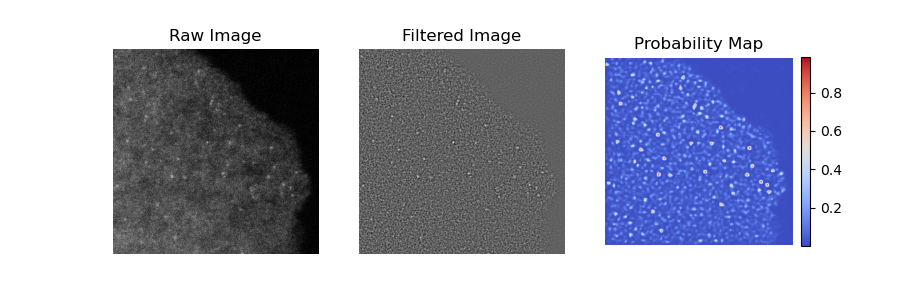

In [45]:
_, axs = plt.subplots(1,3,figsize = (9,3))
ori_im = axs[0].imshow(ori_np, cmap = 'gray')
axs[0].axis("off")
axs[0].set_title("Raw Image")
filt_im = axs[1].imshow(image_np, cmap ='gray')
axs[1].axis("off")
axs[1].set_title("Filtered Image")
pred_im = axs[2].imshow(pred_np , cmap='coolwarm')
axs[2].axis("off")
axs[2].set_title("Probability Map")
cbar = plt.colorbar(pred_im,fraction=0.046, pad=0.04)

## Segmentation and Atom Localization
We now have a Probability Map produced by AtomNet, we want to find the location if each possible atoms. This requires a few steps:
- First, we binarize the probability map using an intensity threshold. In most cases, a probability of >0.5 is sufficient enough. Locations with high probabilities will show up as highlighted regions in segmentation.
- Then, we remove possible noises and separate overlapping atoms based on prior knowledge like resolution and sampling
- Finally, atom location will be extracted

In [46]:
# Segmentation
region = pred_np>0.5

Text(0.5, 1.0, 'Segmented Atom Map')

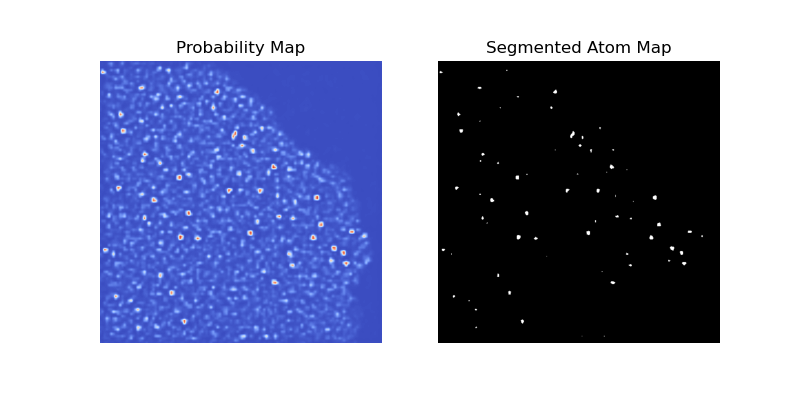

In [47]:
_, axs = plt.subplots(1,2,figsize = (8,4))
pred_im = axs[0].imshow(pred_np , cmap='coolwarm')
axs[0].axis("off")
axs[0].set_title("Probability Map")

seg_im = axs[1].imshow(region , cmap='gray')
axs[1].axis("off")
axs[1].set_title("Segmented Atom Map")

As shown in Segmented map, we find there are some regions with only one or two pixels, and some large blobs that can be overlapping atoms. We can use some prior knowledge of experiment to refine the result. Or we simply take the result and move on.

In this case, the sample is Pt/CN and is acquired at 80kV with magnification of 15 Mx. The resolution is about 1 angstrom and sampling is 0.02613 nm/pix. This means that each atom should be with reasonable size of at least 10 pixels. For 2 overlapping atoms, we suppose that the region will have a major axis larger than 10 pixels. If the region has a major axis larger than 20, we think there are more than two atoms within.

In [48]:
# Label each region
region = region
labels = label(region)
regions = regionprops(labels,ori_np)
points_list = []

In [49]:
# Calibration
cal = 0.02613 #nm/pix

In [50]:
# Set size thresholds
ams = 10 # removal size
aml = 10 # threshold for two atoms
atomr = 3 # radius of each atom
mto = aml*2 # threshold for multiple atom

In [51]:
# Find atoms within large regions 
def find_point(points_list, prob, mask, r):
    prob = prob*mask
    if np.sum(prob)>0:
        result = np.where(prob == np.amax(prob))
        new_point = (result[1][0], result[0][0])
        points_list.append(new_point)
        new_mask = center_removal(mask, [new_point], r)
        points_list = find_point(points_list, prob, new_mask, r)
    return points_list

In [52]:
points_list = []
for i in range(len(regions)):
    #print(points_list)
    props = regions[i]
    y0, x0 = props.weighted_centroid
    axis_major = props.major_axis_length
    axis_minor = props.minor_axis_length
    area = props.area
    #print(area)
    
    # Ignore few-pixel regions
    if area <= ams:
        pass
    # Find centroid of single atoms
    elif axis_major <= aml:
        points_list.append((int(x0), int(y0)))
    # Find locations of multi-atom blobs
    elif axis_major > mto:
        current_region = labels==(i+1)
        current_region = morphology.binary_erosion(current_region)
        current_region = morphology.binary_erosion(current_region)
        # current_region = morphology.binary_erosion(current_region)
        points_list = find_point(points_list, pred_np, current_region, atomr)
    # Find locations of two-atom blobs
    else:
        orientation = props.orientation
        x1 = x0 + math.sin(orientation) * 0.5 * props.major_axis_length / 3
        y1 = y0 + math.cos(orientation) * 0.5 * props.major_axis_length / 3
        x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length / 3
        y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length / 3
        points_list.append((int(x1), int(y1)))
        points_list.append((int(x2), int(y2)))

# Dimer/Trimer Detection

Now that we have all the atom locations in the sample, we are able to find whether there are atoms forms dimer and trimer.

Note that the bond lengths defined here is arbitrary, as the STEM image itself does not show whether two atoms forms bonds or not, even if they are relatively close to each other. Prior knowledge, such as experimental results from spectroscopy will help determine the actual bond length threshold

In [53]:
# set maximal distance to be considered as isolated
# In this example, we set threshold to be 5 angstrom
lb = 0.5/cal # convert to pixel

In [54]:
def find_smallest_dist(dist, points, bi_list, paired_list1, paired_list2, lb):
    if np.min(dist) < lb:
        result = np.where(dist == np.amin(dist))
        dist[result[0][0],  result[1][0]] = np.inf
        dist[result[1][0],  result[0][0]] = np.inf

        for i in paired_list2:
            if (i[0] == result[0][0]) or (i[0] == result[1][0]) or (i[1] == result[0][0]) or (i[1] == result[1][0]):
                dist[i[0], :] = np.inf
                dist[i[1], :] = np.inf
                dist[result[0][0], :] = np.inf
                dist[result[1][0], :] = np.inf
                dist[:, i[0]] = np.inf
                dist[:, i[1]] = np.inf
                dist[:, result[0][0]] = np.inf
                dist[:, result[1][0]] = np.inf
        if not ((result[0][0] in paired_list1) and (result[1][0] in paired_list1)):
            pairs = (points[result[0][0]], points[result[1][0]])
            paired_list2.append((result[0][0], result[1][0]))
            paired_list1.append(result[0][0])
            paired_list1.append(result[1][0])
            bi_list.append(pairs)
        dist, bi_list = find_smallest_dist(dist, points, bi_list, paired_list1, paired_list2, lb)
    return dist, bi_list

def find_bi_tri(points, lb):
    paired_point_list = []
    paired_list1 = []
    paired_list2 = []
    lenth = len(points)
    dist = np.ones((lenth, lenth))*np.inf
    for i in range(lenth):
        for j in range(i+1,lenth):
            dist[i][j] = np.sqrt(np.square(points[i][0]-points[j][0])+np.square(points[i][1]-points[j][1]))

    _, paired_point_list = find_smallest_dist(dist, points, paired_point_list, paired_list1, paired_list2, lb)

    bi_list = []
    tri_list = []
    temp_list1 = []
    temp_list2 = []
    for i in paired_point_list:
        p1, p2 = i
        is_tri = False
        for list in [temp_list1, temp_list2]:
            if p1 in list:
                index = list.index(p1)
                print(index)
                tri_p1 = temp_list1.pop(index)
                tri_p2 = temp_list2.pop(index)
                tri_p3 = p2
                tri_list.append((tri_p1,tri_p2, tri_p3))
                is_tri = True
            if p2 in list:
                index = list.index(p2)
                tri_p1 = temp_list1.pop(index)
                tri_p2 = temp_list2.pop(index)
                tri_p3 = p1
                tri_list.append((tri_p1,tri_p2, tri_p3))
                is_tri = True
        if not is_tri:
            temp_list1.append(p1)
            temp_list2.append(p2)
    for i in range(len(temp_list1)):
        bi_list.append((temp_list1[i],temp_list2[i]))
    return bi_list, tri_list


In [55]:
bi_pairs, tri_pairs = find_bi_tri(points_list, lb)

In [56]:
bi_pairs, tri_pairs

([((242, 135), (244, 131)),
  ((262, 138), (257, 153)),
  ((424, 339), (441, 347))],
 [])

# Statistics

## Calculate pair-wist distance distribution

In [57]:
from scipy.spatial.distance import pdist
import pandas as pd

In [58]:
dists = pdist(points_list)*cal
dists = pd.DataFrame({"Distance (nm)":dists})

In [59]:
len(points_list)

39

In [60]:
len(dists)

741

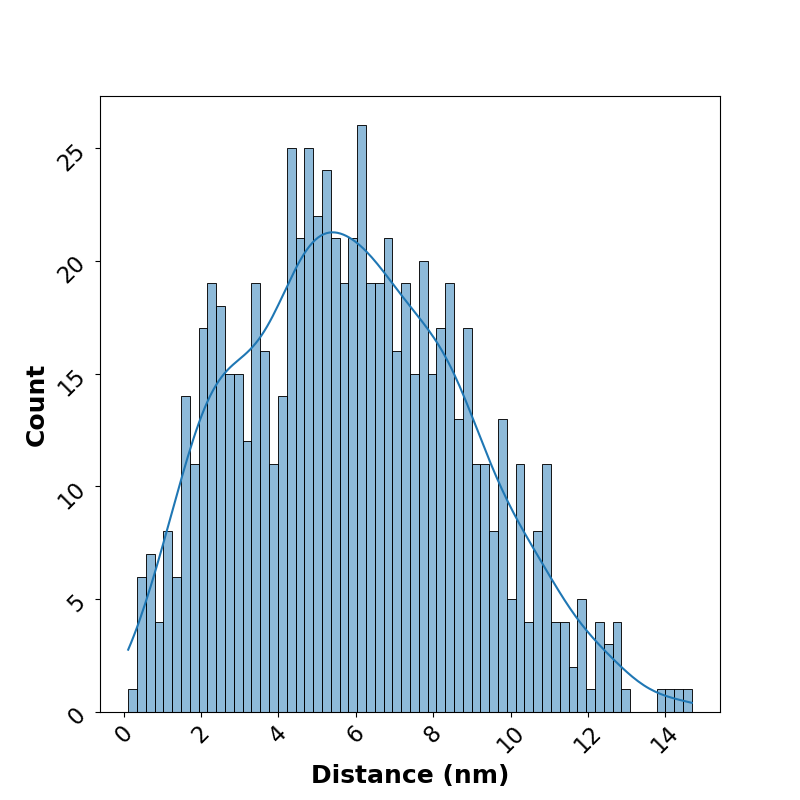

In [61]:
plt.figure(figsize = (8,8))
ax = plt.gca()
sns.histplot(dists, x = "Distance (nm)",bins = 64,kde=True)
ax.set_ylabel("Count",fontsize = 18,weight = 'bold')
ax.set_xlabel("Distance (nm)",fontsize = 18,weight = 'bold')
ax.tick_params(axis='x', labelsize= 16, rotation = 45)
ax.tick_params(axis='y', labelsize= 16, rotation = 45)
#plt.savefig(save_path + "Distance_hist",bbox_inches = 'tight',pad_inches = 0.05, dpi = 200)

## Visualization

Now Let's do some plotting and see how the detection looks like.

In [62]:
def plot_bi(bonds):
    for i in range(len(bonds)):
        bonds = np.array(bonds)
        plt.scatter(bonds[i][:,0],bonds[i][:,1],s = 100, facecolor = 'none', edgecolors='red')
        plt.plot(bonds[i][:,0],bonds[i][:,1],c='r')
    #return img


def plot_tri(bonds):
    for i in range(len(bonds)):
        #bonds = np.array(bonds)
        plt.scatter(bonds[i][:,0],bonds[i][:,1],s = 100, facecolor = 'none', edgecolors='blue')
        t1 = plt.Polygon(bonds[i], facecolor = 'none', edgecolor = 'b')
        plt.gca().add_patch(t1)
    #return img

In [63]:
points_list = np.array(points_list)
bi_pairs = np.array(bi_pairs)
tri_pairs = np.array(tri_pairs)

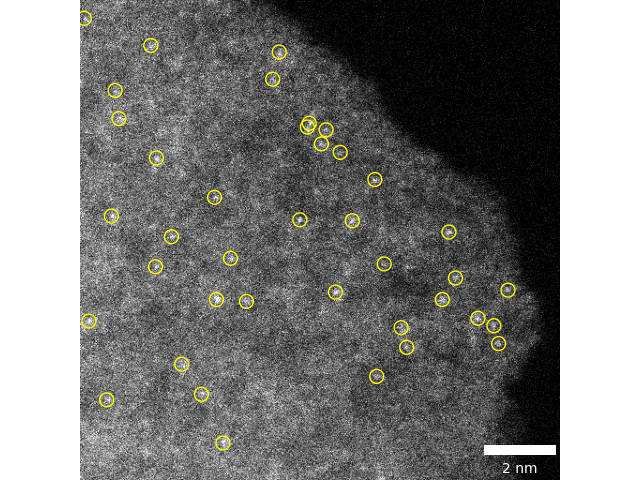

In [64]:
plt.figure()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
ax = plt.gca()
#frame = gaussian_filter(frame,1.5)
ax.imshow(ori_np, cmap = 'gray',vmax = 0.72)
ax.scatter(points_list[:,0],points_list[:,1], s = 100, facecolor = 'none', edgecolors='yellow')
#plot_bi(bi_pairs)
#plot_tri(tri_pairs)
ax.axis('off')
scalebar = ScaleBar(cal, "nm", length_fraction=0.2,color = 'white',box_alpha = 0,width_fraction=0.02,location = 'lower right')
ax.add_artist(scalebar)
#plt.savefig(save_path + "/AtomID.png",bbox_inches = 'tight',pad_inches = 0,dpi=300)

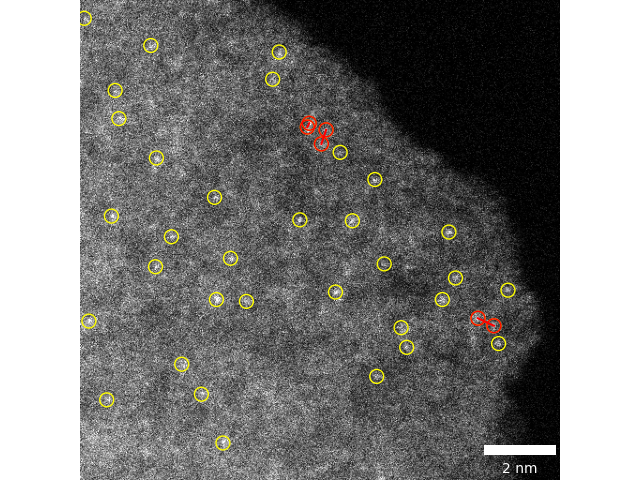

In [65]:
plt.figure()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
ax = plt.gca()
ax.imshow(ori_np, cmap = 'gray',vmax = 0.72)
ax.scatter(points_list[:,0],points_list[:,1], s = 100, facecolor = 'none', edgecolors='yellow')
plot_bi(bi_pairs)
plot_tri(tri_pairs)
ax.axis('off')
scalebar = ScaleBar(cal, "nm", length_fraction=0.2,color = 'white',box_alpha = 0,width_fraction=0.02,location = 'lower right')
ax.add_artist(scalebar)

#plt.savefig(save_path + "Atom_dimer_trimer.png",bbox_inches = 'tight',pad_inches = 0,dpi=300)
#ax.cla()

The results look very reasonable! From this image, we find Pt atoms are all well separated, with at least 5 angstroms away from their neighbours.

Now this set of parameters can be applied to different images, provided that the images are taken at the same conditions.